# Covid-19 visualizations

First, preprocess and clean the data

In [1]:
%reset -f
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import datetime
import re
from IPython.display import clear_output

# fontsizes for plots
BIG_TEXT   = 18
MED_TEXT   = 14
SMALL_TEXT = 10

In [2]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df.rename(columns={
    'cumulative_cases_per_100_000': 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000': 'cumulative_deaths_1e6',
    'new_cases_per_100_000': 'new_cases_1e6', 
    'new_deaths_per_100_000': 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg': 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg': 'new_deaths_7day'
    
}, inplace=True)
df = df.drop(df[~df['location_type'].isin(['county'])].index)
df['fips_code'] = df['fips_code'].astype(np.int64)
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
df.drop(df[df['state']=='Puerto Rico'].index, inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['total_population'] = df['total_population'].astype(np.int64)
df['new_cases'].fillna(value=0, inplace=True)
df['new_deaths'].fillna(value=0, inplace=True)
df['new_cases'].clip(lower=0, inplace=True)
df['new_deaths'].clip(lower=0, inplace=True)
df['new_cases'] = df['new_cases'].astype(np.int64)
df['new_deaths'] = df['new_deaths'].astype(np.int64)
df['new_cases_1e6'].clip(lower=0, inplace=True)
df['new_cases_1e6'].fillna(value=0, inplace=True)
df['new_deaths_1e6'].clip(lower=0, inplace=True)
df['new_deaths_1e6'].fillna(value=0, inplace=True)

In [3]:
def get_cases(level="county", county="Orange", state="California", df=df):
    
    """ A function which filters case_data to a specific county. 
    inputs:  
    level  -- "county" [default] - get county level data
              any other input - get state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    dataFrame -- case_data filtered to a specific county with index=date
    """
    
    if level == "county":
        return  df[(df["location_name"] == county) & (df["state"] == state)].set_index("date")
    
    else: 
        # filter data to desired state
        df = df[df['state'] == state]

        # reindex on location name
        df = df.set_index(["location_name"])

        # get a list of all dates
        all_dates = pd.to_datetime(np.unique(df['date'].to_numpy()))

        # get the state population from county populations
        pop =  sum([(pops/1e5) for pops in df[df['date']==all_dates[0]]['pop']]) 

        # add up the case and death #s that have the same date and state (adding cover counties)
        state_cases       = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['cases_capita' ]]) 
                           for dates in all_dates]

        state_deaths      = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['deaths_capita']]) 
                           for dates in all_dates]

        state_cases_7day  = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['cases_7day'   ]]) 
                           for dates in all_dates]

        state_deaths_7day = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['deaths_7day'  ]]) 
                           for dates in all_dates]
        
        return pd.DataFrame(data={'date'    : all_dates,
                            'cases_capita'  : state_cases, 
                            'deaths_capita' : state_deaths,
                            'cases_7day'    : state_cases_7day,
                            'deaths_7day'   : state_deaths_7day
                            }).set_index(["date"])

In [5]:
def plot_cases(level="county", county="Orange", state="California", df=df, fade=0.75):
    
    """ A function which plots the COVID-19 case/death data and 7 day average
    inputs: 
    level  -- "county" [default] - plot county level data
              any other input - plot state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    [fig, ax] -- figure and axis handles, respectively, for the generated plot
    """
    
    # get the data
    cases = get_cases(level, county, state, df)
        
    # plot the data
    fig, ax = plt.subplots(2, 1, figsize=(12,10), sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style("whitegrid")
    
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","cases_7day"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
    );

    
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","deaths_7day"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
    );
    
    # format and title axes
    fig.autofmt_xdate()
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    
    if level == "county":
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {county} County, {state}");
        
    else: 
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {state}");
    
    
    
    return fig, ax, cases

KeyError: "None of [Index(['cases_capita', 'cases_7day'], dtype='object')] are in the [columns]"

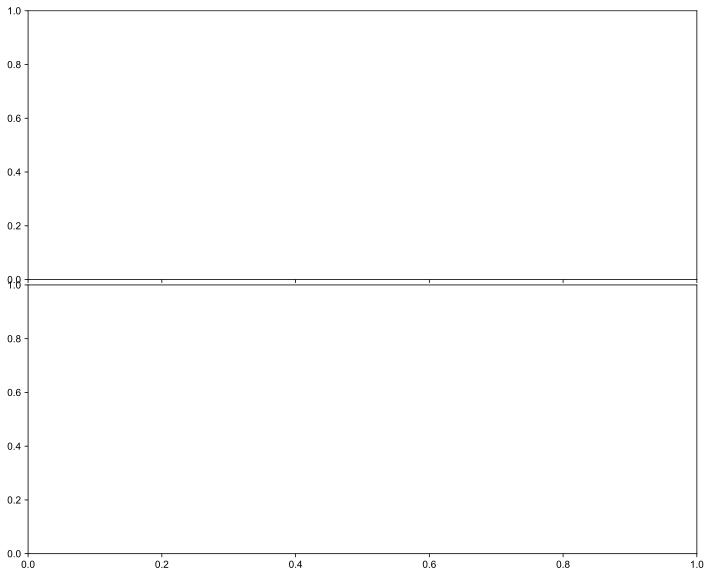

In [6]:
plot_cases(level="county", county="Mecklenburg", state="North Carolina");